**Задание**

Возьмите из прошлого домашнего задания ряд — стационарный и не стационарный.

Приблизьте оба варианта моделями из класса MA.

Оцените качество и пришлите соображения, почему была выбрана та или иная модель.

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
%matplotlib inline

In [ ]:
sales_of_company_x = pd.read_csv("monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("daily-total-female-births-in-cal.csv")

In [ ]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

In [ ]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [ ]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


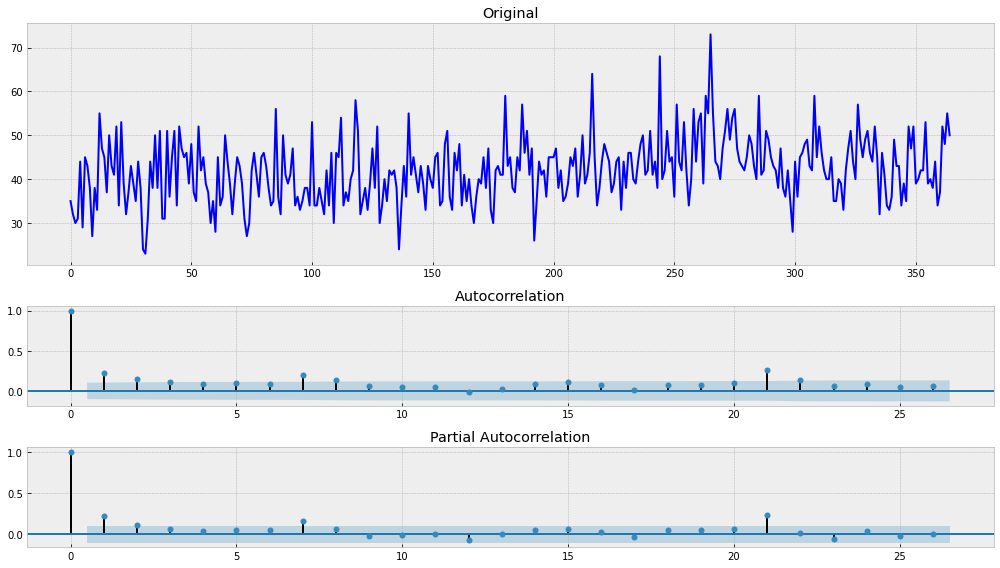

In [ ]:
tsplot(all_series["Daily total female births in California"])

**ряд Daily total female births in California - стационарный**

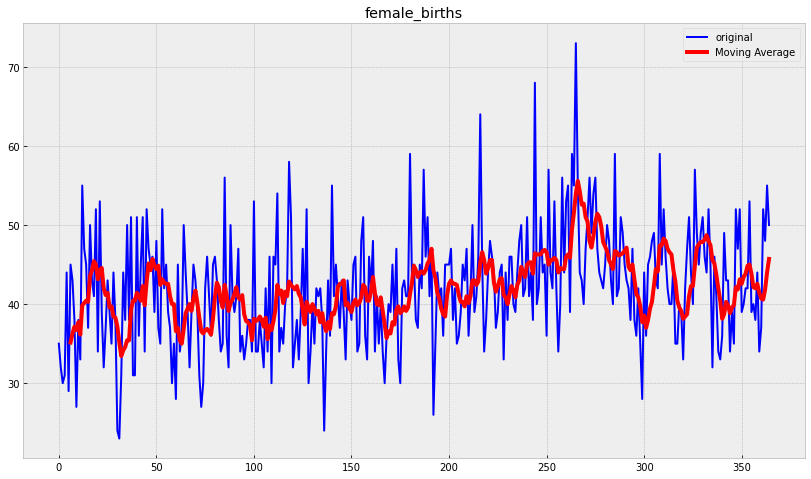

In [ ]:
series = female_births['Count']

# MA - скользящее среднее
ma=series.rolling(7).mean()

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('female_births')
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='4', label='Moving Average')
    plt.legend()

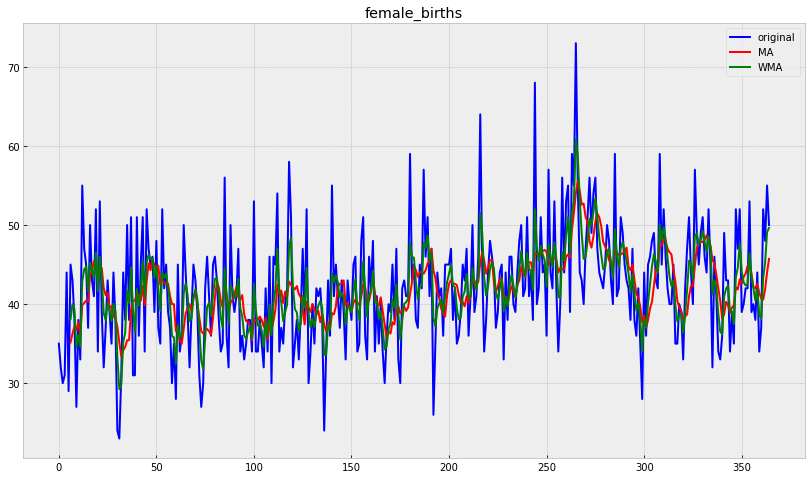

In [ ]:
# WMA - взвешенное скользящее среднее

weights=np.array([1,1,2,3,5,8,13])
wma = series.rolling(7).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('female_births')
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

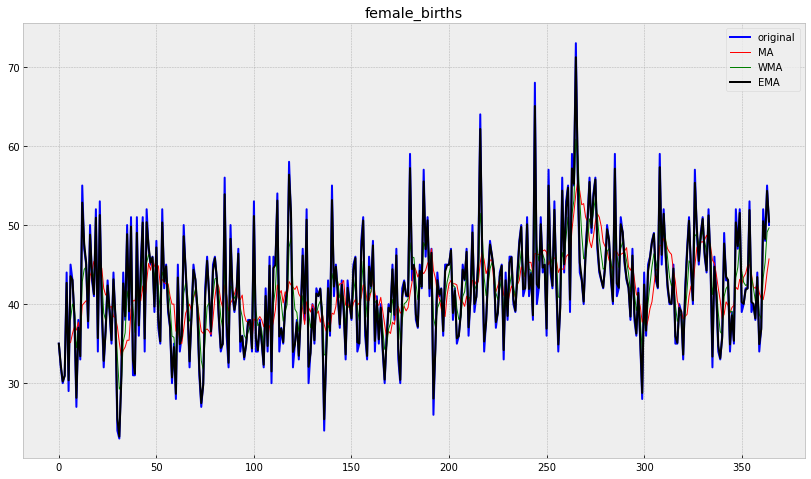

In [ ]:
# EMA - экспоненциальное сглаживание
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

ema = exponential_moving_average(series, 0.9)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('female_births')    
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='1', label='MA')
    plt.plot(wma, color='green', linewidth='1', label='WMA')
    plt.plot(ema, color='black', linewidth='2', label='EMA')
    plt.legend()

описывает ряд 0.9 экспоненциальное сглаживание

**Подбор параметров модели**

In [ ]:
train_size=round(len(series)*.7)
test_size=round(len(series)*.25)
train, val = series[:train_size], series[train_size:]

def mse_cross_val(X,):
    alpha = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    k=0
    for train_split, test_split in split.split(series):
        
        result = exponential_moving_average(train_split, alpha)
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)
        k+=1
        
    return np.mean(np.array(errors))

opt = minimize(mse_cross_val, x0=np.array([0.3]), method="L-BFGS-B", bounds = ((0, 1),))

alpha_opt = opt.x
print(opt)

      fun: 8281.0
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-182.00025715])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([1.])


применение параметров на тестовых данных

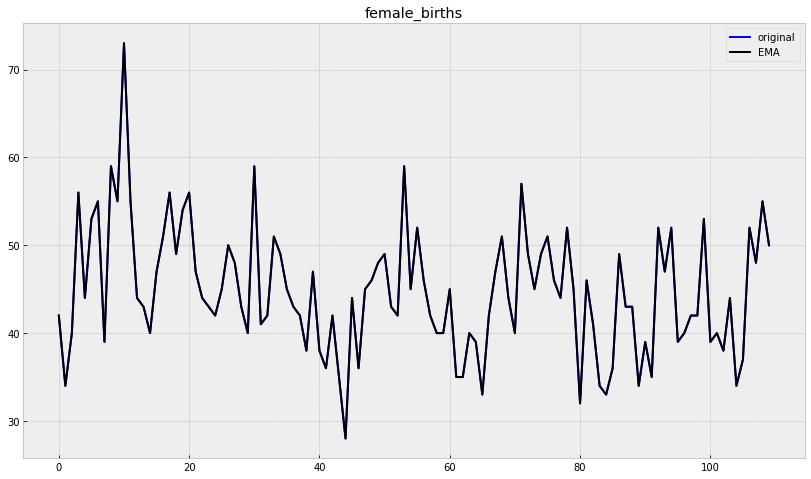

In [ ]:
val = val.reset_index()
val.drop(columns = 'index')
val = val['Count']
ema = exponential_moving_average(val, 1.0)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('female_births')    
    plt.plot(val, color='blue',label='original')
    plt.plot(ema, color='black', linewidth='2', label='EMA')
    plt.legend()

In [ ]:
# Продуктивность модели
r2_score(y_pred=ema, y_true=val)

1.0

вероятно переобучение

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


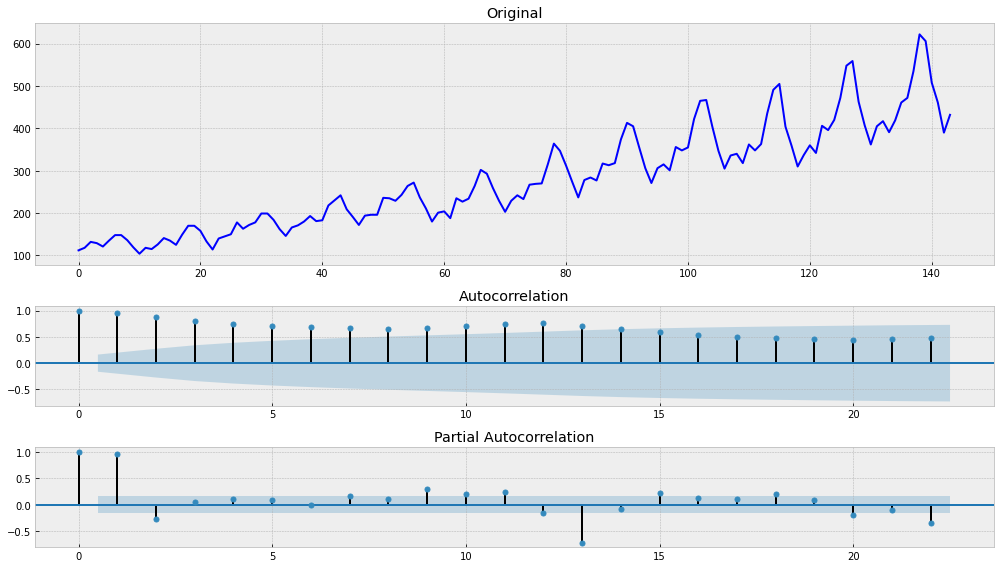

In [ ]:
tsplot(airlines_passengers["Count"])

 **ряд International airline passengers: monthly totals in thousands не стационарный**

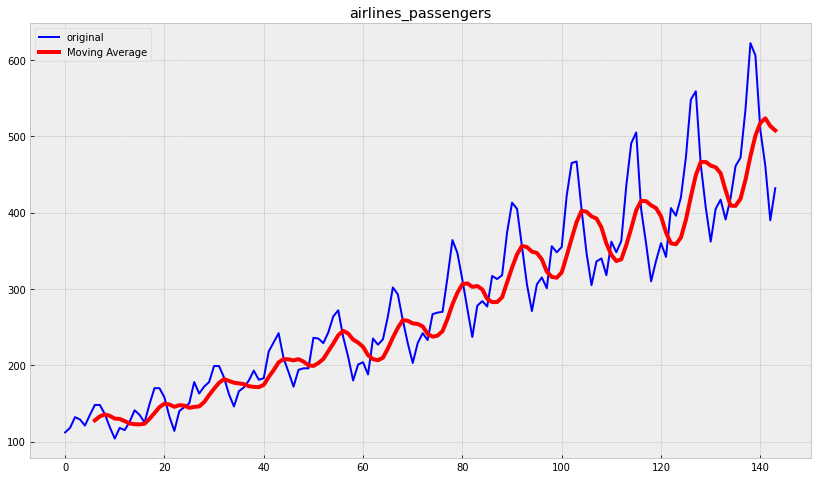

In [ ]:
# MA - скользящее среднее
ma=airlines_passengers.rolling(7).mean()
series = airlines_passengers["Count"]

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('airlines_passengers')
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='4', label='Moving Average')
    plt.legend()


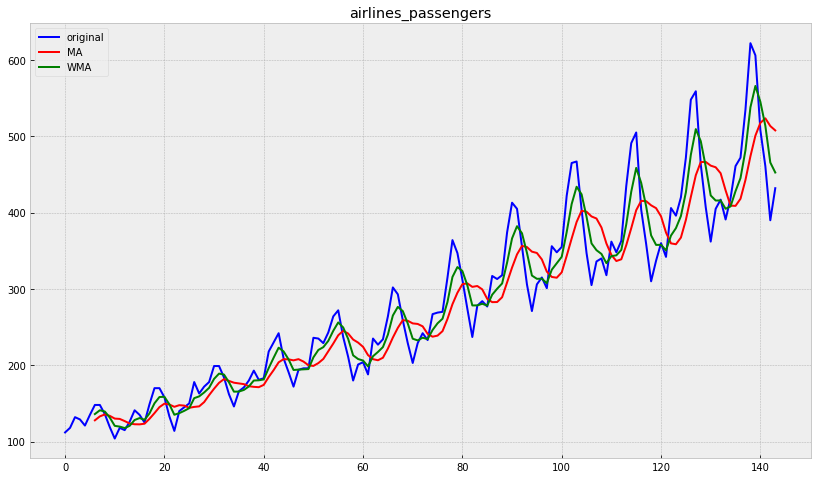

In [ ]:
# WMA - взвешенное скользящее среднее

weights=np.array([1,1,2,3,5,8,13])
wma = airlines_passengers.rolling(7).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
series = airlines_passengers["Count"]

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('airlines_passengers')
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

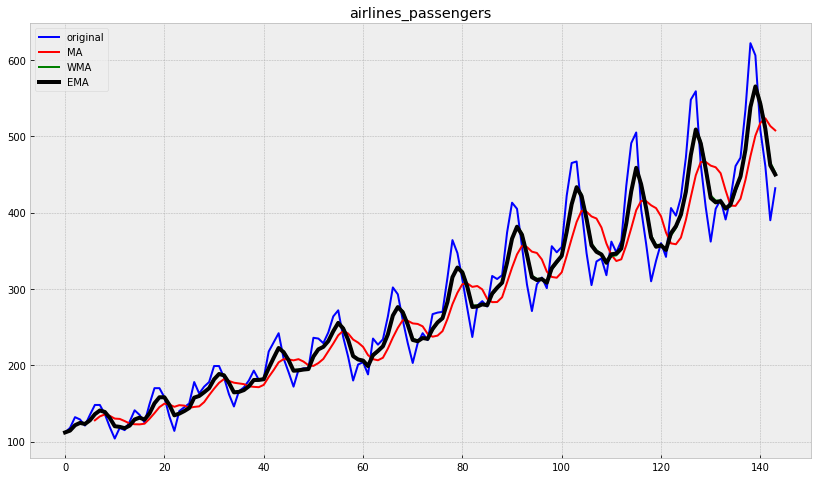

In [ ]:
# EMA - экспоненциальное сглаживание
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

series = airlines_passengers["Count"]
ema = exponential_moving_average(series, 0.4)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('airlines_passengers')    
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

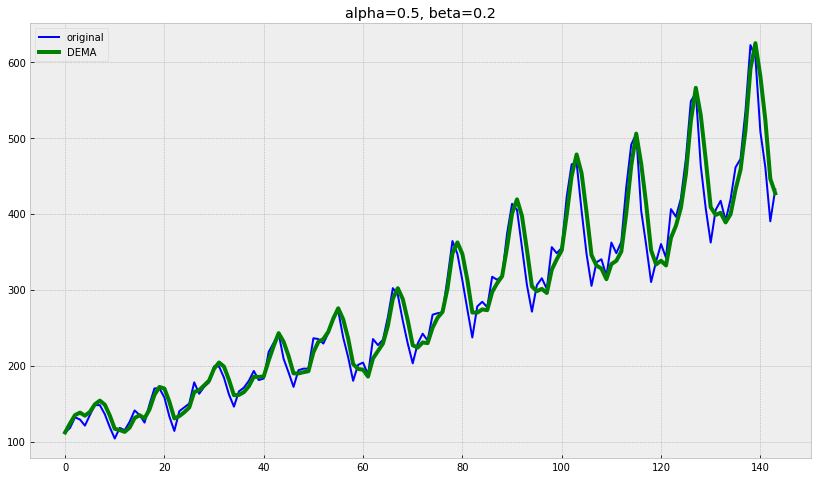

In [ ]:
# DEMA - двойное экспоненциальное сглаживание

def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

alpha=0.5
beta=0.2
series = airlines_passengers["Count"]
dema = double_ema(series, alpha, beta)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('airlines_passengers')    
    plt.plot(series, color='blue',label='original')
    plt.plot(dema, color='green', linewidth='4', label='DEMA')
    plt.title("alpha={}, beta={}".format(alpha, beta))
    plt.legend()

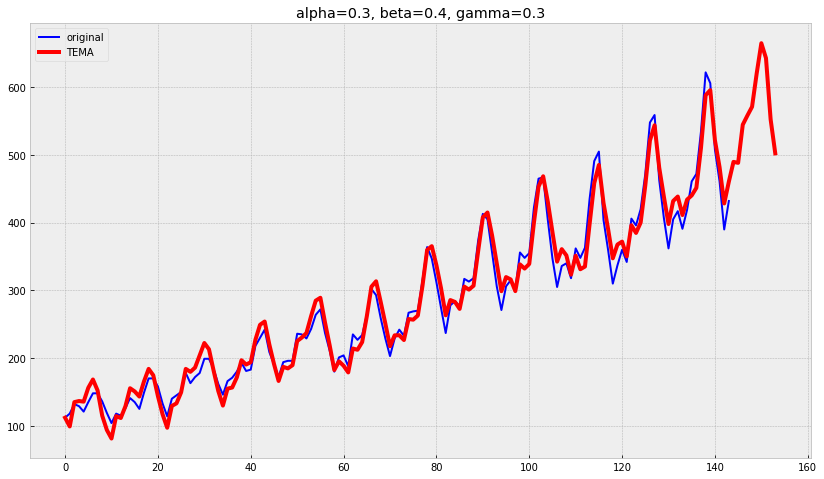

In [ ]:
# tema - Хольт-Винтерс (для учёта сезонности)

def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = sum([float(series[i + slen] - series[i]) / slen]) / slen
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

alpha=0.3
beta=0.4
gamma=0.3
n_periods2_pred=10

series = airlines_passengers["Count"]

tema = triple_exponential_smoothing(series, 12, alpha, beta, gamma, n_periods2_pred)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('airlines_passengers')      
    plt.plot(series, color='blue',label='original')
    plt.plot(tema, color='red', linewidth='4', label='TEMA')
    plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
    plt.legend()


подбор параметров

In [ ]:
series = airlines_passengers["Count"]
train_size=round(len(series)*.7)
test_size=round(len(series)*.25)
train, val = series[:train_size], series[train_size:]

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(mean_monthly_temp):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 9.539210950455393e-09
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.75829832e-06, -7.36708186e-06,  4.12486810e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 340
      nit: 68
     njev: 85
   status: 0
  success: True
        x: array([0.05554688, 0.19055538, 0.91147971])


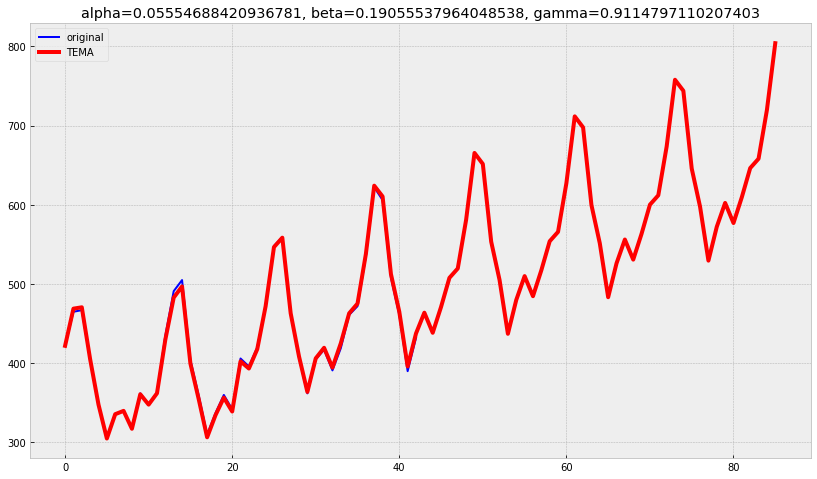

In [ ]:
val = val.reset_index()
val.drop(columns = 'index')
val = val['Count']
tema = triple_exponential_smoothing(val, 12, alpha_opt, beta_opt, gamma_opt, len(val))
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.title('airlines_passengers')      
    plt.plot(val, color='blue',label='original')
    plt.plot(tema, color='red', linewidth='4', label='TEMA')
    plt.title("alpha={}, beta={}, gamma={}".format(alpha_opt, beta_opt, gamma_opt))
    plt.legend()

In [ ]:
# Продуктивность модели
r2_score(y_pred=tema[:len(val)], y_true=val)

0.997976154227483

тут всё ОК при учёте сезонности и тренда